<a href="https://colab.research.google.com/github/jake-joseph/HRV/blob/main/Full_HRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy biosppy hrv-analysis py-ecg-detectors

In [ ]:
#@title Importing Modules
# system imports
import os
#import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing 
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# bio signal processing 
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values,get_time_domain_features
from ecgdetectors import Detectors

# misc
import warnings
import glob
from datetime import timedelta

In [ ]:
#@title Loading vitaldb stuff
# %load vitaldb
import gzip
from scipy import signal
import numpy as np
import pandas as pd
import datetime
from struct import pack, unpack_from, Struct

unpack_b = Struct('<b').unpack_from
unpack_w = Struct('<H').unpack_from
unpack_s = Struct('<h').unpack_from
unpack_f = Struct('<f').unpack_from
unpack_d = Struct('<d').unpack_from
unpack_dw = Struct('<L').unpack_from
pack_b = Struct('<b').pack
pack_w = Struct('<H').pack
pack_s = Struct('<h').pack
pack_f = Struct('<f').pack
pack_d = Struct('<d').pack
pack_dw = Struct('<L').pack


def unpack_str(buf, pos):
    strlen = unpack_dw(buf, pos)[0]
    pos += 4
    val = buf[pos:pos + strlen].decode('utf-8', 'ignore')
    pos += strlen
    return val, pos


def pack_str(s):
    sutf = s.encode('utf-8')
    return pack_dw(len(sutf)) + sutf


# 4 byte L (unsigned) l (signed)
# 2 byte H (unsigned) h (signed)
# 1 byte B (unsigned) b (signed)
def parse_fmt(fmt):
    if fmt == 1:
        return 'f', 4
    elif fmt == 2:
        return 'd', 8
    elif fmt == 3:
        return 'b', 1
    elif fmt == 4:
        return 'B', 1
    elif fmt == 5:
        return 'h', 2
    elif fmt == 6:
        return 'H', 2
    elif fmt == 7:
        return 'l', 4
    elif fmt == 8:
        return 'L', 4
    return '', 0


class VitalFile:
    def __init__(self, ipath, dtnames=None):
        self.load_vital(ipath, dtnames)

    def get_samples(self, dtname, interval=1):
        if not interval:
            return None

        trk = self.find_track(dtname)
        if not trk:
            return None

        # 리턴 할 길이
        nret = int(np.ceil((self.dtend - self.dtstart) / interval))

        if trk['type'] == 2:  # numeric track
            ret = np.full(nret, np.nan)  # create a dense array
            for rec in trk['recs']:  # copy values
                idx = int((rec['dt'] - self.dtstart) / interval)
                if idx < 0:
                    idx = 0
                elif idx > nret:
                    idx = nret
                ret[idx] = rec['val']
            return ret
        elif trk['type'] == 1:  # wave track
            srate = trk['srate']
            recs = trk['recs']

            # 자신의 srate 만큼 공간을 미리 확보
            nsamp = int(np.ceil((self.dtend - self.dtstart) * srate))
            ret = np.full(nsamp, np.nan)

            # 실제 샘플을 가져와 채움
            for rec in recs:
                sidx = int(np.ceil((rec['dt'] - self.dtstart) * srate))
                eidx = sidx + len(rec['val'])
                srecidx = 0
                erecidx = len(rec['val'])
                if sidx < 0:  # self.dtstart 이전이면
                    srecidx -= sidx
                    sidx = 0
                if eidx > nsamp:  # self.dtend 이후이면
                    erecidx -= (eidx - nsamp)
                    eidx = nsamp
                ret[sidx:eidx] = rec['val'][srecidx:erecidx]

            # gain offset 변환
            if trk['fmt'] > 2:  # 1: float, 2: double
                ret *= trk['gain']
                ret += trk['offset']

            # 리샘플 변환
            if srate != int(1 / interval + 0.5):
                ret = np.take(ret, np.linspace(0, nsamp - 1, nret).astype(np.int64))

            return ret

        return None

    def find_track(self, dtname):
        dname = None
        tname = dtname
        if dtname.find('/') != -1:
            dname, tname = dtname.split('/')

        for trk in self.trks.values():  # find track
            if trk['name'] == tname:
                did = trk['did']
                if did == 0 or not dname:
                    return trk                    
                if did in self.devs:
                    dev = self.devs[did]
                    if 'name' in dev and dname == dev['name']:
                        return trk

        return None

    def save_vital(self, ipath, compresslevel=1):
        f = gzip.GzipFile(ipath, 'wb', compresslevel=compresslevel)

        # save header
        if not f.write(b'VITA'):  # check sign
            return False
        if not f.write(pack_dw(3)):  # version
            return False
        if not f.write(pack_w(10)):  # header len
            return False
        if not f.write(self.header):  # save header
            return False

        # save devinfos
        for did, dev in self.devs.items():
            if did == 0: continue
            ddata = pack_dw(did) + pack_str(dev['name']) + pack_str(dev['type']) + pack_str(dev['port'])
            if not f.write(pack_b(9) + pack_dw(len(ddata)) + ddata):
                return False

        # save trkinfos
        for tid, trk in self.trks.items():
            ti = pack_w(tid) + pack_b(trk['type']) + pack_b(trk['fmt']) + pack_str(trk['name']) \
                + pack_str(trk['unit']) + pack_f(trk['mindisp']) + pack_f(trk['maxdisp']) \
                + pack_dw(trk['col']) + pack_f(trk['srate']) + pack_d(trk['gain']) + pack_d(trk['offset']) \
                + pack_b(trk['montype']) + pack_dw(trk['did'])
            if not f.write(pack_b(0) + pack_dw(len(ti)) + ti):
                return False

            # save recs
            for rec in trk['recs']:
                rdata = pack_w(10) + pack_d(rec['dt']) + pack_w(tid)  # infolen + dt + tid (= 12 bytes)
                if trk['type'] == 1:  # wav
                    rdata += pack_dw(len(rec['val'])) + rec['val'].tobytes()
                elif trk['type'] == 2:  # num
                    fmtcode, fmtlen = parse_fmt(trk['fmt'])
                    rdata += pack(fmtcode, rec['val'])
                elif trk['type'] == 5:  # str
                    rdata += pack_dw(0) + pack_str(rec['val'])

                if not f.write(pack_b(1) + pack_dw(len(rdata)) + rdata):
                    return False

        # save trk order
        if hasattr(self, 'trkorder'):
            cdata = pack_b(5) + pack_w(len(self.trkorder)) + self.trkorder.tobytes()
            if not f.write(pack_b(6) + pack_dw(len(cdata)) + cdata):
                return False

        f.close()
        return True

    def load_vital(self, ipath, dtnames=None):
        if isinstance(dtnames, str):
            if dtnames.find(','):
                dtnames = dtnames.split(',')
            else:
                dtnames = [dtnames]

        # dtnames: 로딩을 원하는 dtname 의 리스트. dtnames가 None 이면 트랙 목록만 읽혀짐
        f = gzip.GzipFile(ipath, 'rb')

        # parse header
        if f.read(4) != b'VITA':  # check sign
            return False

        f.read(4)  # file version

        buf = f.read(2)
        if buf == b'':
            return False

        headerlen = unpack_w(buf, 0)[0]
        self.header = f.read(headerlen)  # skip header
        self.dgmt = unpack_s(self.header, 0)[0]  # ut - dgmt = localtime

        # parse body
        self.devs = {0: {}}  # device names. did = 0 represents the vital recorder
        self.trks = {}
        self.dtstart = 0
        self.dtend = 0

        try:
            sel_tids = set()
            while True:
                buf = f.read(5)
                if buf == b'':
                    break
                pos = 0

                packet_type = unpack_b(buf, pos)[0]; pos += 1
                packet_len = unpack_dw(buf, pos)[0]; pos += 4

                buf = f.read(packet_len)
                if buf == b'':
                    break
                pos = 0

                if packet_type == 9:  # devinfo
                    did = unpack_dw(buf, pos)[0]; pos += 4
                    devtype, pos = unpack_str(buf, pos)
                    name, pos = unpack_str(buf, pos)
                    if len(buf) > pos + 4:  # port는 없을 수 있다
                        port, pos = unpack_str(buf, pos)
                    if not name:
                        name = devtype
                    self.devs[did] = {'name': name, 'type': devtype, 'port': port}
                elif packet_type == 0:  # trkinfo
                    did = col = 0
                    montype = unit = ''
                    gain = offset = srate = mindisp = maxdisp = 0.0
                    tid = unpack_w(buf, pos)[0]; pos += 2
                    trktype = unpack_b(buf, pos)[0]; pos += 1
                    fmt = unpack_b(buf, pos)[0]; pos += 1
                    tname, pos = unpack_str(buf, pos)

                    if packet_len > pos:
                        unit, pos = unpack_str(buf, pos)
                    if packet_len > pos:
                        mindisp = unpack_f(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        maxdisp = unpack_f(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        col = unpack_dw(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        srate = unpack_f(buf, pos)[0]
                        pos += 4
                    if packet_len > pos:
                        gain = unpack_d(buf, pos)[0]
                        pos += 8
                    if packet_len > pos:
                        offset = unpack_d(buf, pos)[0]
                        pos += 8
                    if packet_len > pos:
                        montype = unpack_b(buf, pos)[0]
                        pos += 1
                    if packet_len > pos:
                        did = unpack_dw(buf, pos)[0]
                        pos += 4

                    dname = ''
                    if did and did in self.devs:
                        if did and did in self.devs:
                            dname = self.devs[did]['name']
                        dtname = dname + '/' + tname
                    else:
                        dtname = tname

                    if dtnames:  # 사용자가 특정 트랙만 읽으라고 했을 때
                        matched = False
                        if dtname in dtnames:  # dtname (현재 읽고 있는 트랙명)이 dtnames에 지정된 것과 정확히 일치할 때
                            matched = True
                        else:
                            for sel_dtname in dtnames:
                                if dtname.endswith('/' + sel_dtname) or (dname + '/*' == sel_dtname): # 트랙명만 지정 or 특정 장비의 모든 트랙일 때
                                    matched = True
                                    sel_tids.add(tid)
                                    break
                                    
                        if not matched:
                            continue
                        sel_tids.add(tid)  # 앞으로는 sel_tids 에서 체크한다

                    # dtnames가 None 이거나 사용자가 원하는 sel 일 때
                    self.trks[tid] = {'name': tname, 'dtname': dtname, 'type': trktype, 'fmt': fmt, 'unit': unit, 'srate': srate,
                                      'mindisp': mindisp, 'maxdisp': maxdisp, 'col': col, 'montype': montype,
                                      'gain': gain, 'offset': offset, 'did': did, 'recs': []}
                elif packet_type == 1:  # rec
                    infolen = unpack_w(buf, pos)[0]; pos += 2
                    dt = unpack_d(buf, pos)[0]; pos += 8
                    tid = unpack_w(buf, pos)[0]; pos += 2
                    pos = 2 + infolen

                    if self.dtstart == 0 or dt < self.dtstart:
                        self.dtstart = dt
                    
                    # TODO: dtrec end 는 다를 수 있음 wav 읽어서 nsamp 로딩해야함
                    if dt > self.dtend:
                        self.dtend = dt

                   # if not dtnames:  # dtnames 가 None 이면 트랙 목록만 읽혀짐
                    #    continue

                    if tid not in self.trks:  # 이전 정보가 없는 트랙이거나
                        continue
                 #   if tid not in sel_tids:  # 사용자가 트랙 지정을 한 경우
                 #       continue

                    trk = self.trks[tid]  

                    fmtlen = 4
                    # gain, offset 변환은 하지 않은 raw data 상태로만 로딩한다.
                    # 항상 이 변환이 필요하지 않기 때문에 변환은 get_samples 에서 나중에 한다.
                    if trk['type'] == 1:  # wav
                        fmtcode, fmtlen = parse_fmt(trk['fmt'])
                        nsamp = unpack_dw(buf, pos)[0]; pos += 4
                        samps = np.ndarray((nsamp,), buffer=buf, offset=pos, dtype=np.dtype(fmtcode)); pos += nsamp * fmtlen
                        trk['recs'].append({'dt': dt, 'val': samps})
                    elif trk['type'] == 2:  # num
                        fmtcode, fmtlen = parse_fmt(trk['fmt'])
                        val = unpack_from(fmtcode, buf, pos)[0]; pos += fmtlen
                        trk['recs'].append({'dt': dt, 'val': val})
                    elif trk['type'] == 5:  # str
                        pos += 4  # skip
                        s, pos = unpack_str(buf, pos)
                        trk['recs'].append({'dt': dt, 'val': s})
                elif packet_type == 6:  # cmd
                    cmd = unpack_b(buf, pos)[0]; pos += 1
                    if cmd == 6:  # reset events
                        evt_trk = self.find_track('/EVENT')
                        if evt_trk:
                            evt_trk['recs'] = []
                    elif cmd == 5:  # trk order
                        cnt = unpack_w(buf, pos)[0]; pos += 2
                        self.trkorder = np.ndarray((cnt,), buffer=buf, offset=pos, dtype=np.dtype('H')); pos += cnt * 2

        except EOFError as error:
            print(error)
            pass

        # sorting tracks
        # for trk in self.trks.values():
        #     trk['recs'].sort(key=lambda r:r['dt'])

        f.close()
        return True


def load_trk(tid, interval=1):
    try:
        url = 'https://api.vitaldb.net/' + tid
        dtvals = pd.read_csv(url, na_values='-nan(ind)').values
    except:
        return np.empty(0)

    if len(dtvals) == 0:
        return np.empty(0)
    
    dtvals[:,0] /= interval  # convert time to row
    nsamp = int(np.nanmax(dtvals[:,0])) + 1  # find maximum index (array length)
    ret = np.full(nsamp, np.nan)  # create a dense array
    
    if np.isnan(dtvals[:,0]).any():  # wave track
        if nsamp != len(dtvals):  # resample
            ret = np.take(dtvals[:,1], np.linspace(0, len(dtvals) - 1, nsamp).astype(np.int64))
        else:
            ret = dtvals[:,1]
    else:  # numeric track
        for idx, val in dtvals:  # copy values
            ret[int(idx)] = val

    return ret


def load_trks(tids, interval=1):
    trks = []
    maxlen = 0
    for tid in tids:
        trk = load_trk(tid, interval)
        trks.append(trk)
        if len(trk) > maxlen:
            maxlen = len(trk)
    if maxlen == 0:
        return np.empty(0)
    ret = np.full((maxlen, len(tids)), np.nan)  # create a dense array
    for i in range(len(tids)):  # copy values
        ret[:len(trks[i]), i] = trks[i]
    return ret

def vital_recs(ipath, dtnames, interval=0.3, return_timestamp=False, return_datetime=False):
    if not dtnames:
        return []

    # 만일 SNUADC/ECG_II,Solar8000 형태의 문자열이면?
    if isinstance(dtnames, str):
        if dtnames.find(',') != -1:
            dtnames = dtnames.split(',')
        else:
            dtnames = [dtnames]

    vf = VitalFile(ipath, dtnames)

    nrows = int(np.ceil((vf.dtend - vf.dtstart) / interval))
    if not nrows:
        return []

    ret = []
    for dtname in dtnames:
        col = vf.get_samples(dtname, interval)
        if col is None:
            col = np.full(nrows, np.nan)
        ret.append(col)
    if not ret:
        return []

    # return time column
    if return_datetime: # in this case, numpy array with object type will be returned
        tzi = datetime.timezone(datetime.timedelta(minutes=-vf.dgmt))
        dts = datetime.datetime.fromtimestamp(vf.dtstart, tzi)
        dte = dts + datetime.timedelta(seconds=len(ret[0]))
        ret.insert(0, [dts + datetime.timedelta(seconds=i*interval) for i in range(len(ret[0]))])
    elif return_timestamp:
        ret.insert(0, np.arange(vf.dtstart, vf.dtend, interval))

    ret = np.transpose(ret)

    return ret

def vital_trks(ipath):
    # 트랙 목록만 읽어옴
    ret = []
    vf = VitalFile(ipath)
    for trk in vf.trks.values():
        tname = trk['name']
        dname = ''
        did = trk['did']
        if did in vf.devs:
            dev = vf.devs[did]
            if 'name' in dev:
                dname = dev['name']
        ret.append(dname + '/' + tname)
    return ret


# api files
dftrks = None

def load_case(tnames, caseid=None, interval=1):
    global dftrks

    if not caseid:
        return None
    if dftrks is None:
        dftrks = pd.read_csv("https://api.vitaldb.net/trks")

    tids = []
    for tname in tnames:
        tid = dftrks[(dftrks['caseid'] == caseid) & (dftrks['tname'] == tname)]['tid'].values[0]
        tids.append(tid)
    
    return load_trks(tids, interval)


def load_cases(tnames, caseids=None, interval=1, maxcases=1):
    global dftrks

    # find the caseids which contains tnames
    if not isinstance(tnames, list):
        if isinstance(tnames, str):
            tnames = tnames.split(',')
        else:
            return None

    if interval == 0:
        return None

    if not caseids:
        if dftrks is None:
            dftrks = pd.read_csv("https://api.vitaldb.net/trks")

        # filter cases which don't have all tnames
        caseids = None
        for tname in tnames:
            matched = set(dftrks[dftrks['tname'] == tname]['caseid'])
            if caseids is None:
                caseids = matched
            else:
                caseids = caseids & matched
        
    cases = {}
    for caseid in caseids:
        case = load_case(tnames, caseid, interval)
        if case is None:
            continue
        if len(case) == 0:
            continue
        cases[caseid] = case
        if len(cases) >= maxcases:
            break

    return cases

In [ ]:
#@title class that contains our vital data for future use
from scipy import ndimage
class VitalDBData:
    def __init__(self,vital_file):
        vital_data = VitalFile(vital_file)
        ecg_settings = vital_data.find_track('ECG_I')
        
        self.sampling_rate = ecg_settings['srate']
        self.ecg_I = vital_data.get_samples('ECG_I', 1/self.sampling_rate)
        self.ecg_II = vital_data.get_samples('ECG_II', 1/self.sampling_rate)
        self.ecg_III = vital_data.get_samples('ECG_III', 1/self.sampling_rate)
        self.ch1 = vital_data.get_samples('CH1', 1/self.sampling_rate)
        self.starttime = datetime.datetime.fromtimestamp(vital_data.dtstart)
        self.endtime = datetime.datetime.fromtimestamp(vital_data.dtend)
        self.__loadCh1Info(vital_data)
        self.__removeNaNs()
        
    def __removeNaNs(self):
        nan_time = np.isnan(self.ecg_I)
        self.ecg_I[nan_time]=0
        self.ecg_II[nan_time]=0
        self.ecg_III[nan_time]=0
        self.ch1[nan_time]=0
        self.ch1_envelope[nan_time]=0
        print("Removing data:" )
        print(timedelta(seconds= np.sum(nan_time)/self.sampling_rate))
        self.starttime=self.starttime+timedelta(seconds= np.sum(nan_time)/self.sampling_rate)
        self.t=np.arange(len(self.ecg_I))/(self.sampling_rate)
        
        
    def __loadCh1Info(self,vital_data):
        ch_settings = vital_data.find_track('CH1')
        ch_srate = ch_settings['srate']
        ch1_raw = vital_data.get_samples('CH1', 1/self.sampling_rate)
        ch1_raw[np.isnan(ch1_raw)]=0
        #calculate envelope
        self.ch1_envelope=ndimage.maximum_filter(ch1_raw, size=self.sampling_rate)
        self.ch1_envelope = ndimage.median_filter(self.ch1_envelope, size=10*round(self.sampling_rate))
        self.ch1_envelope = self.ch1_envelope > 0.05
        
        
    
        
        #downsample to match other data

In [ ]:
search_dir = 'C:\\Users\\Jake\\Box\\taVNS_clinical'
vit_subject_dir= os.listdir(search_dir)
stim_names = []
for i,subj in enumerate(vit_subject_dir): #looping through taVNS folder, subj is patient
  print(i)
  if not subj.isnumeric():
    continue
  mu = []
  var=[]
  thresh = []
  vit_files_dir = os.listdir(os.path.join(search_dir,subj)) 
  for vit_dir in vit_files_dir: #looping through the days for patient
    vit_files=os.scandir(os.path.join(search_dir,subj,vit_dir))
    for j,vital_filename in enumerate(vit_files): #looping through file for that day
      if not vital_filename.name.endswith('.vital'):
        continue
      vital_file = os.path.join(search_dir,subj,vit_dir,vital_filename)
      print('Loading',vital_file)
      vital_data = VitalFile(vital_file)
      ch1 = vital_data.get_samples('CH1', 1/500.0)
      if ch1 is not None:
        if not mu:
          baseline = os.listdir(os.path.join(search_dir,subj,vit_dir))
          vital_base = VitalFile(os.path.join(search_dir,subj,vit_dir,baseline[-2]))
          if vital_base is not None:
            ch1_base = vital_base.get_samples('CH1', 1/500.0)
            mu = np.nanmean(ch1_base)
            sigma = np.nanstd(ch1_base)
          thresh=np.nanmax(((ch1-mu)/sigma)**2)*2
          print('Calculating mu and sigma')
          print(thresh)
        plt.plot((ch1-mu)/sigma)
        plt.show()
        print(np.nanmax((ch1-mu)/sigma)**2)
        if(np.nanmax((ch1-mu)/sigma)**2 > thresh):
          print('Stim in',vital_filename)
          stim_names.append([subj,vital_file])
      else:
        continue
df = pd.DataFrame(stim_names)
df.to_csv('stimfiles.csv', index=False)

In [ ]:
df = open('C:\\Users\\Jake\\Downloads\\stim.csv') #scanning through all stims to manually check
file = csv.reader(df)
next(file)
for row in file:
    data = VitalDBData(row[1])
    plt.plot(data.t/60,data.ch1)
    plt.plot(data.t/60,data.ch1_envelope)
    plt.title(row[1])
    plt.xlabel("Time (min)", fontsize=16)
    plt.ylabel("Voltage (mV)")
    plt.show()

In [ ]:
def extract(data,first,last):
  detectors = Detectors(data.sampling_rate)
  time = (20*500*60)
  max = data.ecg_I.size
  dur = extract_helper(data.ecg_I[first:last],detectors)
  pre = extract_helper(data.ecg_I[first-time:first],detectors)
  try:
    post = extract_helper(data.ecg_I[last:last+time],detectors)
  except:
    pass 
  if first-time <0:
    pre = NaN
  if last+time > max:
    post = NaN
  return pre, dur, post

def extract_helper(data, detectors):
  rpeaks = detectors.two_average_detector(data)
  rr_intervals = np.diff(rpeaks)
  rr_intervals = rr_intervals*1e3/data.sampling_rate # convert to ms
  rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals)
  interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,interpolation_method="linear")
  nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
  interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
  get_time_domain_features(interpolated_nn_intervals)['rmssd']

In [ ]:
df = open('C:\\Users\\Jake\\Downloads\\stim_pass.csv') #extracting data
file = csv.reader(df)
shame_hrv = []
stim_hrv = []
next(file)
for i,row in enumerate(file):
    data = VitalDBData(row[1])
    print(i,row[1])
    plt.plot(data.t/60,data.ch1)
    plt.plot(data.t/60,data.ch1_envelope)
    first_stim = np.where(data.ch1_envelope == True)[0][0] 
    last_stim = np.where(data.ch1_envelope == True)[-1][-1] 
    plt.axvline(x=first_stim/500/60,color='r')
    plt.axvline(x=last_stim/500/60,color='r')
    plt.xlabel("Time (min)", fontsize=16)
    plt.ylabel("Voltage (mV)")
    plt.show()
    if row[3] == 0:
      cpre, cdur, cpost = extract(data,first_stim,last_stim)
      sham_hrv.append([cpre,cdur,cpost])
    else:
      spre, sdur, spost = extract(data,first_stim,last_stim)
      stim_hrv.append([spre,sdur,spost])

In [ ]:
def import_data(data):
  # Read CSV
  df = pd.read_csv(data,index_col="Time", usecols=["Time", "ECG_II",'CH1'])

  # Convert string to dates with following parser format 
  df.index = pd.to_datetime(df.index, format="%Y-%m-%d %H:%M:%S.%f")

  # Convert the column data using SIMD
  df.index = df.index.astype(np.int64) /  int(1e6)

  #set first to 0
  df.index = [x- df.index[0]  for x in df.index]

  #Removing gap after first second
  df.dropna(inplace=True) 

  return df

In [ ]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [ ]:
def group_peaks(p, threshold=0.5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

Compressed file ended before the end-of-stream marker was reached
Removing data:
0:22:53.650000
0:36:58.750856


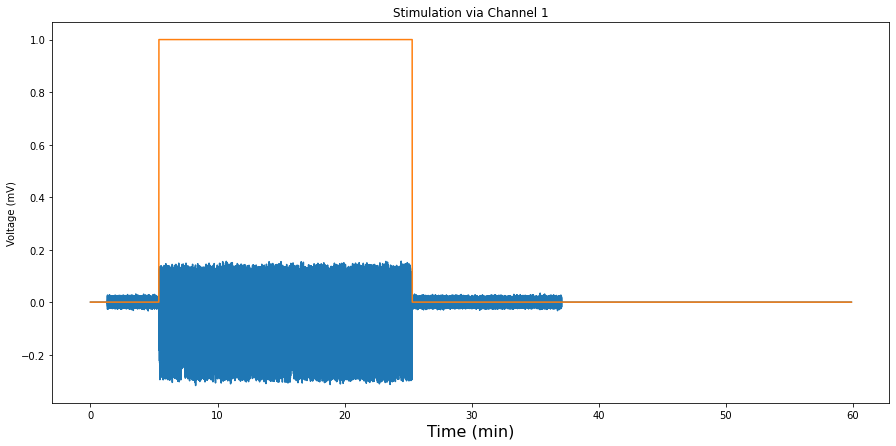

In [ ]:

#df = import_data('/content/HR18829_210222_200000.csv')
data = VitalDBData('/content/taVNS_clinical/202011/210629/HR18826_210629_075547.vital')
#Visualizing the stimulation

plt.figure(figsize=(15,7))
plt.plot(data.t/60,data.ch1)
plt.plot(data.t/60,data.ch1_envelope)
plt.title('Stimulation via Channel 1')
plt.xlabel("Time (min)", fontsize=16)
plt.ylabel("Voltage (mV)")
print(data.endtime-data.starttime)
plt.show()

1 outlier(s) have been deleted.
The outlier(s) value(s) are : [42512.0]
201 ectopic beat(s) have been deleted with malik rule.


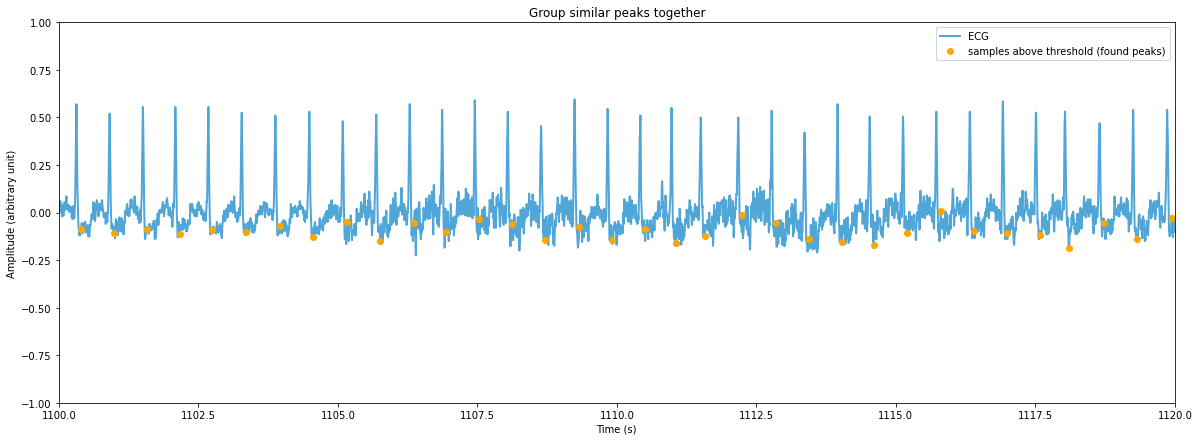

In [ ]:
# detect peaks
# peaks, similarity = detect_peaks(df.ECG_II[start:stop],threshold=0.5)
detectors = Detectors(data.sampling_rate)
rpeaks = detectors.two_average_detector(data.ecg_I)
# group peaks so we get a single peak per beat (hopefully)
# grouped_peaks = group_peaks(peaks,10)
rr_intervals = np.diff(rpeaks)
rr_intervals = rr_intervals*1e3/data.sampling_rate # convert to ms
rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals)

interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,interpolation_method="linear")
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(data.t,data.ecg_I, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(data.t[rpeaks],data.ecg_I[rpeaks] ,label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (arbitrary unit)")
# uncomment this to make sure that peaks are being correctly detected
# plt.gca().set_xlim(15000,16000)   
plt.gca().set_xlim(1100,1120)
plt.gca().set_ylim((-1,1))
plt.show()

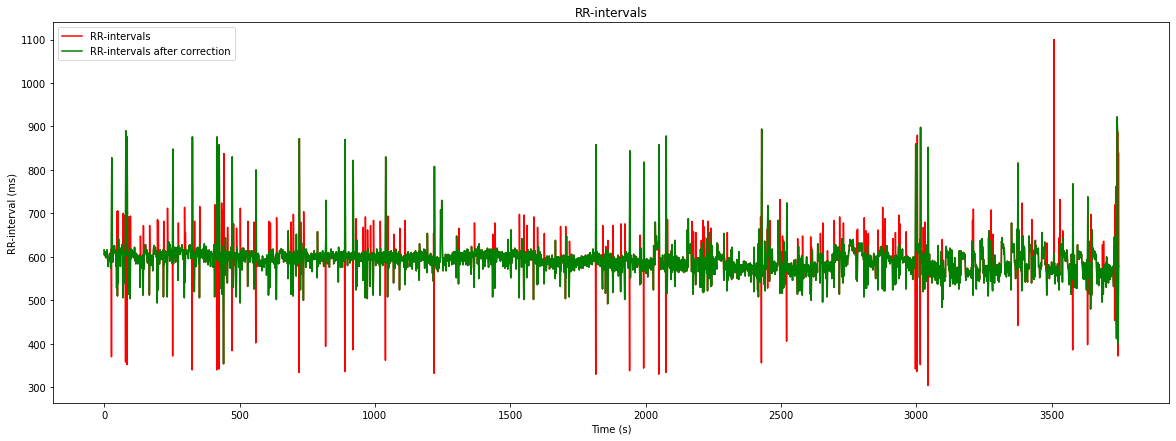

In [ ]:
plt.figure(figsize=(20, 7))

# RR-intervals are the differences between successive peaks
# rr = np.diff(grouped_peaks)
# #removing any outliers beyond 2 standard deviations
# rr_corrected = rr.copy()
# rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")

plt.plot(interpolated_rr_intervals, color="red", label="RR-intervals")
plt.plot(interpolated_nn_intervals, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

In [ ]:
print((data.ch1_envelope))

[False False False ... False False False]


In [ ]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [ ]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in get_time_domain_features(interpolated_nn_intervals).items():
    print("- %s: %.2f" % (k, v))

print()

Time domain metrics - automatically corrected RR-intervals:
- mean_nni: 593.63
- sdnn: 38.19
- sdsd: 35.58
- nni_50: 429.00
- pnni_50: 11.45
- nni_20: 1124.00
- pnni_20: 29.99
- rmssd: 35.58
- median_nni: 594.00
- range_nni: 568.00
- cvsd: 0.06
- cvnni: 0.06
- mean_hr: 101.45
- max_hr: 169.49
- min_hr: 65.08
- std_hr: 5.99



In [ ]:
def full_hrv(df, metric,stim=3):
  df['CH1'] = df['CH1'].abs()
  start = df['ECG_II'].first_valid_index()
  stop = df['ECG_II'].last_valid_index()
  if (df['CH1'] >= 2).any():
    first_stim = df.where(df['CH1'] >= 2).first_valid_index()
    last_stim = df.where(df['CH1'] >= 2).last_valid_index()
    if stim == 1:
      peaks,_ = detect_peaks(df.ECG_II[start:first_stim], threshold=0.5)
    elif stim ==2:
      peaks,_ = detect_peaks(df.ECG_II[first_stim:last_stim], threshold=0.5)
    else:
      peaks,_ = detect_peaks(df.ECG_II[last_stim:stop], threshold=0.5)
  else:
    peaks,_ = detect_peaks(df.ECG_II[start:stop], threshold=0.5)

  grouped_peaks = group_peaks(peaks,10)
  rr = np.diff(grouped_peaks)
  rr[np.abs(zscore(rr)) > 2] = np.median(rr)
  results = timedomain(rr)
  return results[metric]

In [ ]:
stim_RMSSD = []
no_RMSSD = []
metric = 'RMSSD (ms)'
filenames = sorted(glob.glob('HR18829*.vital'))
for file in filenames:
  print(file)
  df = import_data(file)
  if (df['CH1'] >= 2).any():
    no_RMSSD.append(full_hrv(df,metric,1))
    no_RMSSD.append(full_hrv(df,metric))
    stim_RMSSD.append(full_hrv(df,metric,2))
  else:
    no_RMSSD.append(full_hrv(df,metric))

print(['%.2f' % item for item in stim_RMSSD])
print(['%.2f' % item for item in no_RMSSD])


HR18829_210222_200000.csv
HR18829_210304_230000.csv
['214.72']
['252.76', '233.01', '152.16']


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<Figure size 720x504 with 0 Axes>

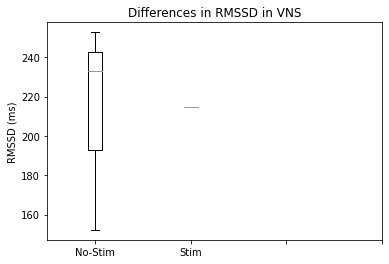

In [ ]:
plt.figure(figsize=(10,7))
fig, ax = plt.subplots()
ax.boxplot([no_RMSSD,stim_RMSSD])
plt.xticks([1,2,3,4],['No-Stim', 'Stim'])
plt.ylabel('RMSSD (ms)')
plt.title('Differences in RMSSD in VNS')
plt.show()